<a href="https://colab.research.google.com/github/noQils/mini_project_cv/blob/main/Mini_Project_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 2: Imports and basic config

import os
import random
from glob import glob

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as vutils

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ==== CONFIG ====
# TODO: change this to your actual dataset path
DATA_DIR = r"C:\Users\TUF\Downloads\Mini Project\triplets_out"  # <-- EDIT THIS

ORIG_DIR   = os.path.join(DATA_DIR, "orig")
ERASED_DIR = os.path.join(DATA_DIR, "erased")
MASK_DIR   = os.path.join(DATA_DIR, "masks")

OUTPUT_DIR = r"C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE   = 128          # resize all images to 128x128
BATCH_SIZE = 16
NUM_EPOCHS = 70           # adjust if needed
LR         = 1e-4
VAL_SPLIT  = 0.1          # 10% for test/val

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [ ]:
# NEW CELL: VGG16 feature extractor for perceptual loss

from torchvision.models import vgg16, VGG16_Weights

# Load VGG16 pretrained on ImageNet, only feature layers up to relu3_3 (sekitar layer 16)
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES).features[:16].to(DEVICE)
vgg.eval()
for p in vgg.parameters():
    p.requires_grad = False

# ImageNet normalization for VGG
vgg_mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
vgg_std  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)

def perceptual_loss(pred, target):
    """
    pred, target: [B,3,H,W] in [0,1]
    """
    # normalize to ImageNet statistics
    pred_n   = (pred   - vgg_mean) / vgg_std
    target_n = (target - vgg_mean) / vgg_std

    feat_pred   = vgg(pred_n)
    feat_target = vgg(target_n)

    return torch.mean(torch.abs(feat_pred - feat_target))


In [ ]:
# CELL 3: Build file list and train/test split

def collect_triplets(orig_dir, erased_dir, mask_dir, ext="png"):
    orig_files = sorted(glob(os.path.join(orig_dir, f"*.{ext}")))
    triplets = []

    for orig_path in orig_files:
        base_name = os.path.basename(orig_path)
        name_no_ext = os.path.splitext(base_name)[0]

        erased_path = os.path.join(erased_dir, f"{name_no_ext}_erased.{ext}")
        mask_path   = os.path.join(mask_dir,  f"{name_no_ext}_mask.{ext}")

        if os.path.exists(erased_path) and os.path.exists(mask_path):
            triplets.append({
                "base": name_no_ext,
                "orig": orig_path,
                "erased": erased_path,
                "mask": mask_path
            })
        else:
            # If needed, print missing pairs for debugging
            # print("Missing pair for:", name_no_ext)
            pass
    return triplets

triplets = collect_triplets(ORIG_DIR, ERASED_DIR, MASK_DIR, ext="png")
print(f"Total triplets found: {len(triplets)}")

# Shuffle and split into train and test
random.seed(42)
random.shuffle(triplets)

num_total = len(triplets)
num_test  = int(num_total * VAL_SPLIT)

test_triplets  = triplets[:num_test]
train_triplets = triplets[num_test:]

print(f"Train size: {len(train_triplets)}")
print(f"Test  size: {len(test_triplets)}")


Total triplets found: 3437
Train size: 3094
Test  size: 343


In [ ]:
# CELL 4: PyTorch Dataset

class InpaintingDataset(Dataset):
    def __init__(self, triplets, img_size=256, preload=False):
        self.triplets = triplets
        self.img_size = img_size
        self.preload = preload

        # Use separate transforms for image and mask
        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),   # will be [1, H, W]
        ])

        if self.preload:
            self.data = []
            for item in self.triplets:
                # item is a dict with keys: "orig", "erased", "mask", "base"
                orig_img   = Image.open(item["orig"]).convert("RGB")
                erased_img = Image.open(item["erased"]).convert("RGB")
                mask_img   = Image.open(item["mask"]).convert("L")

                orig   = self.img_transform(orig_img)      # [3,H,W]
                erased = self.img_transform(erased_img)    # [3,H,W]
                mask   = self.mask_transform(mask_img)     # [1,H,W]

                # Binarize mask: 1 = missing region, 0 = valid region
                mask = (mask > 0.5).float()

                # Input to the model: concat erased image with mask channel -> [4,H,W]
                model_input = torch.cat([erased, mask], dim=0)

                self.data.append({
                    "input": model_input,  # [4,H,W]
                    "target": orig,        # [3,H,W]
                    "erased": erased,      # [3,H,W]
                    "mask": mask,          # [1,H,W]
                    "name": item["base"],
                })

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        if self.preload:
            return self.data[idx]

        # Non-preload path: compute on the fly
        item = self.triplets[idx]

        orig_img   = Image.open(item["orig"]).convert("RGB")
        erased_img = Image.open(item["erased"]).convert("RGB")
        mask_img   = Image.open(item["mask"]).convert("L")  # single-channel

        orig   = self.img_transform(orig_img)      # [3,H,W]
        erased = self.img_transform(erased_img)    # [3,H,W]
        mask   = self.mask_transform(mask_img)     # [1,H,W]

        # Binarize mask
        mask = (mask > 0.5).float()

        # Input to the model: concat erased image with mask channel -> [4,H,W]
        model_input = torch.cat([erased, mask], dim=0)

        return {
            "input": model_input,  # [4,H,W]
            "target": orig,        # [3,H,W]
            "erased": erased,      # [3,H,W]
            "mask": mask,          # [1,H,W]
            "name": item["base"],
        }


# Build DataLoaders
train_dataset = InpaintingDataset(train_triplets, img_size=IMG_SIZE, preload=True)
test_dataset  = InpaintingDataset(test_triplets,  img_size=IMG_SIZE, preload=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

test_loader  = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))

Train batches: 194
Test  batches: 22


In [ ]:
# CELL 5: Simple UNet implementation for inpainting

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        in_ch = in_channels
        for feature in features:
            self.downs.append(DoubleConv(in_ch, feature))
            in_ch = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # transpose conv
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return torch.sigmoid(self.final_conv(x))  # output in [0,1]


model = UNet(in_channels=4, out_channels=3).to(DEVICE)
print("Model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Model parameters: 31044227


In [ ]:
# CELL 6: Loss, optimizer, scheduler (fixed)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# FIXED: remove verbose=True → PyTorch 2.x no longer supports it
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

# Masked L1 loss
def masked_l1_loss(pred, target, mask, alpha=1.0, beta=0.1):
    missing = (mask > 0.5).float()

    if missing.sum() > 0:
        loss_missing = (torch.abs(pred - target) * missing).sum() / (missing.sum() * 3.0)
    else:
        loss_missing = torch.tensor(0.0, device=pred.device)

    loss_global = torch.mean(torch.abs(pred - target))

    return alpha * loss_missing + beta * loss_global

def total_loss(pred, target, mask,
               alpha_l1=3.0, beta_l1=0.05,
               gamma_perc=0.05):
    """
    total loss = masked L1 (fokus ke area hilang) + perceptual loss
    gamma_perc: weight perceptual loss (besar → lebih tajam tapi bisa artefak)
    """
    l1 = masked_l1_loss(pred, target, mask,
                        alpha=alpha_l1,
                        beta=beta_l1)
    pl = perceptual_loss(pred, target)

    return l1 + gamma_perc * pl

In [ ]:
# CELL 7: Training loop (fixed name clash with total_loss function)

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0  # was total_loss

    pbar = tqdm(loader, desc="Train", leave=False)
    for batch in pbar:
        inp    = batch["input"].to(DEVICE)   # [B,4,H,W]
        target = batch["target"].to(DEVICE)  # [B,3,H,W]
        mask   = batch["mask"].to(DEVICE)    # [B,1,H,W]

        optimizer.zero_grad()
        output = model(inp)                  # [B,3,H,W]

        # pakai fungsi total_loss yang kita definisikan di Cell 6
        loss = total_loss(output, target, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inp.size(0)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return running_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0  # was total_loss

    pbar = tqdm(loader, desc="Val", leave=False)
    for batch in pbar:
        inp    = batch["input"].to(DEVICE)
        target = batch["target"].to(DEVICE)
        mask   = batch["mask"].to(DEVICE)

        output = model(inp)
        loss = total_loss(output, target, mask)

        running_loss += loss.item() * inp.size(0)
        pbar.set_postfix({"val_loss": f"{loss.item():.4f}"})

    return running_loss / len(loader.dataset)

In [ ]:
# CELL 8: Main training loop + save best model

best_val_loss = float("inf")
best_model_path = os.path.join(OUTPUT_DIR, "best_unet_inpainting.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss   = validate(model, test_loader)

    scheduler.step(val_loss)

    print(f"Epoch {epoch}: train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> New best model saved at {best_model_path} (val_loss={val_loss:.4f})")

print("Training finished. Best val_loss:", best_val_loss)



Epoch 1/70


Epoch 1: train_loss = 0.3080 | val_loss = 0.2002
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.2002)

Epoch 2/70


Epoch 2: train_loss = 0.1833 | val_loss = 0.1510
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.1510)

Epoch 3/70


Epoch 3: train_loss = 0.1562 | val_loss = 0.1226
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.1226)

Epoch 4/70


Epoch 4: train_loss = 0.1384 | val_loss = 0.1103
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.1103)

Epoch 5/70


Epoch 5: train_loss = 0.1266 | val_loss = 0.1177

Epoch 6/70


Epoch 6: train_loss = 0.1198 | val_loss = 0.1047
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.1047)

Epoch 7/70


Epoch 7: train_loss = 0.1123 | val_loss = 0.0898
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0898)

Epoch 8/70


Epoch 8: train_loss = 0.1044 | val_loss = 0.0990

Epoch 9/70


Epoch 9: train_loss = 0.1010 | val_loss = 0.0878
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0878)

Epoch 10/70


Epoch 10: train_loss = 0.0945 | val_loss = 0.0835
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0835)

Epoch 11/70


Epoch 11: train_loss = 0.0895 | val_loss = 0.0865

Epoch 12/70


Epoch 12: train_loss = 0.0865 | val_loss = 0.0818
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0818)

Epoch 13/70


Epoch 13: train_loss = 0.0799 | val_loss = 0.0772
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0772)

Epoch 14/70


Epoch 14: train_loss = 0.0797 | val_loss = 0.0749
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0749)

Epoch 15/70


Epoch 15: train_loss = 0.0779 | val_loss = 0.0748
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0748)

Epoch 16/70


Epoch 16: train_loss = 0.0749 | val_loss = 0.0717
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0717)

Epoch 17/70


Epoch 17: train_loss = 0.0720 | val_loss = 0.0768

Epoch 18/70


Epoch 18: train_loss = 0.0709 | val_loss = 0.0800

Epoch 19/70


Epoch 19: train_loss = 0.0694 | val_loss = 0.0739

Epoch 20/70


Epoch 20: train_loss = 0.0670 | val_loss = 0.0658
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0658)

Epoch 21/70


Epoch 21: train_loss = 0.0673 | val_loss = 0.0702

Epoch 22/70


Epoch 22: train_loss = 0.0641 | val_loss = 0.0655
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0655)

Epoch 23/70


Epoch 23: train_loss = 0.0629 | val_loss = 0.0682

Epoch 24/70


Epoch 24: train_loss = 0.0622 | val_loss = 0.0703

Epoch 25/70


Epoch 25: train_loss = 0.0604 | val_loss = 0.0628
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0628)

Epoch 26/70


Epoch 26: train_loss = 0.0598 | val_loss = 0.0658

Epoch 27/70


Epoch 27: train_loss = 0.0589 | val_loss = 0.0607
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0607)

Epoch 28/70


Epoch 28: train_loss = 0.0586 | val_loss = 0.0631

Epoch 29/70


Epoch 29: train_loss = 0.0557 | val_loss = 0.0634

Epoch 30/70


Epoch 30: train_loss = 0.0554 | val_loss = 0.0608

Epoch 31/70


Epoch 31: train_loss = 0.0536 | val_loss = 0.0597
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0597)

Epoch 32/70


Epoch 32: train_loss = 0.0538 | val_loss = 0.0601

Epoch 33/70


Epoch 33: train_loss = 0.0539 | val_loss = 0.0581
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0581)

Epoch 34/70


Epoch 34: train_loss = 0.0516 | val_loss = 0.0605

Epoch 35/70


Epoch 35: train_loss = 0.0521 | val_loss = 0.0591

Epoch 36/70


Epoch 36: train_loss = 0.0520 | val_loss = 0.0578
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0578)

Epoch 37/70


Epoch 37: train_loss = 0.0512 | val_loss = 0.0665

Epoch 38/70


Epoch 38: train_loss = 0.0512 | val_loss = 0.0560
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0560)

Epoch 39/70


Epoch 39: train_loss = 0.0501 | val_loss = 0.0601

Epoch 40/70


Epoch 40: train_loss = 0.0476 | val_loss = 0.0601

Epoch 41/70


Epoch 41: train_loss = 0.0486 | val_loss = 0.0588

Epoch 42/70


Epoch 42: train_loss = 0.0479 | val_loss = 0.0577

Epoch 43/70


Epoch 43: train_loss = 0.0472 | val_loss = 0.0568

Epoch 44/70


Epoch 44: train_loss = 0.0471 | val_loss = 0.0616

Epoch 45/70


Epoch 45: train_loss = 0.0425 | val_loss = 0.0526
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0526)

Epoch 46/70


Epoch 46: train_loss = 0.0397 | val_loss = 0.0509
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0509)

Epoch 47/70


Epoch 47: train_loss = 0.0401 | val_loss = 0.0534

Epoch 48/70


Epoch 48: train_loss = 0.0392 | val_loss = 0.0519

Epoch 49/70


Epoch 49: train_loss = 0.0394 | val_loss = 0.0524

Epoch 50/70


Epoch 50: train_loss = 0.0385 | val_loss = 0.0523

Epoch 51/70


Epoch 51: train_loss = 0.0383 | val_loss = 0.0513

Epoch 52/70


Epoch 52: train_loss = 0.0379 | val_loss = 0.0518

Epoch 53/70


Epoch 53: train_loss = 0.0353 | val_loss = 0.0503
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0503)

Epoch 54/70


Epoch 54: train_loss = 0.0342 | val_loss = 0.0493
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0493)

Epoch 55/70


Epoch 55: train_loss = 0.0348 | val_loss = 0.0505

Epoch 56/70


Epoch 56: train_loss = 0.0345 | val_loss = 0.0496

Epoch 57/70


Epoch 57: train_loss = 0.0333 | val_loss = 0.0507

Epoch 58/70


Epoch 58: train_loss = 0.0334 | val_loss = 0.0497

Epoch 59/70


Epoch 59: train_loss = 0.0336 | val_loss = 0.0485
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0485)

Epoch 60/70


Epoch 60: train_loss = 0.0330 | val_loss = 0.0504

Epoch 61/70


Epoch 61: train_loss = 0.0325 | val_loss = 0.0488

Epoch 62/70


Epoch 62: train_loss = 0.0327 | val_loss = 0.0493

Epoch 63/70


Epoch 63: train_loss = 0.0329 | val_loss = 0.0484
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0484)

Epoch 64/70


Epoch 64: train_loss = 0.0333 | val_loss = 0.0493

Epoch 65/70


Epoch 65: train_loss = 0.0324 | val_loss = 0.0485

Epoch 66/70


Epoch 66: train_loss = 0.0325 | val_loss = 0.0501

Epoch 67/70


Epoch 67: train_loss = 0.0326 | val_loss = 0.0511

Epoch 68/70


Epoch 68: train_loss = 0.0320 | val_loss = 0.0516

Epoch 69/70


Epoch 69: train_loss = 0.0318 | val_loss = 0.0489

Epoch 70/70


Epoch 70: train_loss = 0.0306 | val_loss = 0.0480
  -> New best model saved at C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth (val_loss=0.0480)
Training finished. Best val_loss: 0.04798323684982934


In [ ]:
# CELL 9: Load best model and evaluate PSNR + SSIM (fixed)

# Load best weights
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

def tensor_to_image(t):
    """
    Convert tensor [3,H,W] in [0,1] to uint8 HxWx3 numpy array.
    """
    t = t.detach().cpu().clamp(0, 1)
    arr = (t.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
    return arr

@torch.no_grad()
def evaluate_metrics(model, loader):
    psnr_list = []
    ssim_list = []

    pbar = tqdm(loader, desc="Eval", leave=False)
    for batch in pbar:
        inp    = batch["input"].to(DEVICE)
        target = batch["target"]
        output = model(inp)  # [B,3,H,W]

        for i in range(output.size(0)):
            gt_img   = tensor_to_image(target[i])
            pred_img = tensor_to_image(output[i])

            # PSNR OK
            psnr_val = peak_signal_noise_ratio(
                gt_img, pred_img, data_range=255
            )

            # FIXED: gunakan channel_axis instead of multichannel
            ssim_val = structural_similarity(
                gt_img,
                pred_img,
                data_range=255,
                channel_axis=-1,  # channels on last axis (H,W,C)
                win_size=7        # default, aman untuk 128x128
            )

            psnr_list.append(psnr_val)
            ssim_list.append(ssim_val)

    psnr_mean = float(np.mean(psnr_list)) if psnr_list else 0.0
    ssim_mean = float(np.mean(ssim_list)) if ssim_list else 0.0

    return psnr_mean, ssim_mean

mean_psnr, mean_ssim = evaluate_metrics(model, test_loader)
print(f"Test PSNR: {mean_psnr:.4f} dB")
print(f"Test SSIM: {mean_ssim:.4f}")


C:\Users\TUF\AppData\Local\Temp\ipykernel_22464\638233359.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=

Test PSNR: 31.6749 dB
Test SSIM: 0.9599


In [ ]:
# CELL 10: Save sample images (input, output, target) for report

SAMPLES_DIR = os.path.join(OUTPUT_DIR, "samples")
os.makedirs(SAMPLES_DIR, exist_ok=True)

@torch.no_grad()
def save_samples(model, loader, num_batches=3):
    model.eval()
    saved = 0

    for batch_idx, batch in enumerate(loader):
        if batch_idx >= num_batches:
            break

        inp    = batch["input"].to(DEVICE)
        target = batch["target"].to(DEVICE)
        erased = batch["erased"].to(DEVICE)
        mask   = batch["mask"].to(DEVICE)
        names  = batch["name"]

        output = model(inp)

        for i in range(output.size(0)):
            name = names[i]

            # Stack: [erased, output, target] horizontally
            grid = vutils.make_grid(
                torch.stack([erased[i], output[i], target[i]], dim=0),
                nrow=3
            )
            img_path = os.path.join(SAMPLES_DIR, f"{name}_triplet.png")
            vutils.save_image(grid, img_path)

            saved += 1

    print(f"Saved {saved} sample triplet images in {SAMPLES_DIR}")

save_samples(model, test_loader, num_batches=5)


Saved 80 sample triplet images in C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\samples


In [ ]:
# CELL 11: Inference function for new images (OTI / HTI)

single_img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

single_mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

@torch.no_grad()
def inpaint_single(erased_path, mask_path, output_path):
    """
    erased_path: path to corrupted image
    mask_path:   path to mask image
    output_path: where to save reconstructed image
    """
    model.eval()

    erased_img = Image.open(erased_path).convert("RGB")
    mask_img   = Image.open(mask_path).convert("L")

    erased = single_img_transform(erased_img)  # [3,H,W]
    mask   = single_mask_transform(mask_img)   # [1,H,W]
    mask   = (mask > 0.5).float()

    model_input = torch.cat([erased, mask], dim=0).unsqueeze(0).to(DEVICE)  # [1,4,H,W]

    pred = model(model_input)[0]  # [3,H,W]

    vutils.save_image(pred, output_path)
    print(f"Saved inpainted image to: {output_path}")

# Example usage (edit paths when you have an OTI/HTI sample):
# inpaint_single(
#     erased_path="/content/path_to_erased.png",
#     mask_path="/content/path_to_mask.png",
#     output_path=os.path.join(OUTPUT_DIR, "hti_result.png")
# )


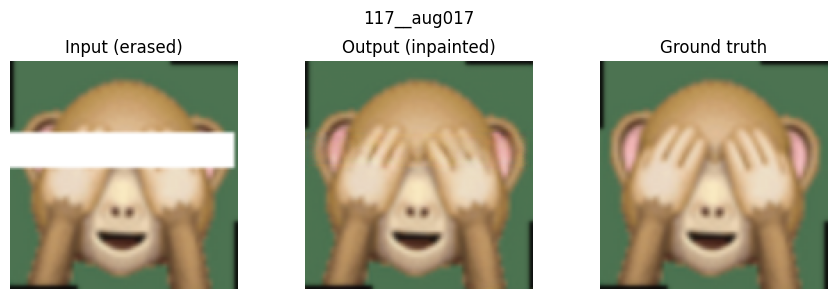

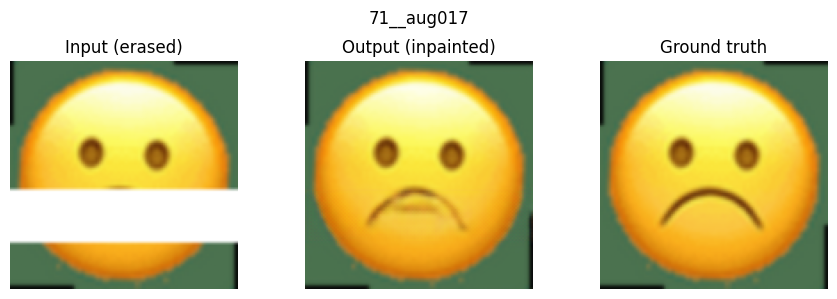

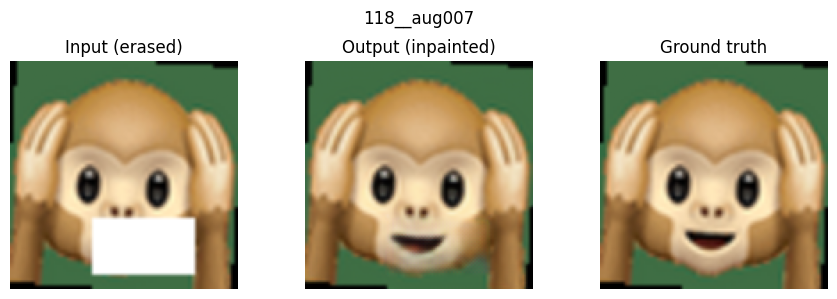

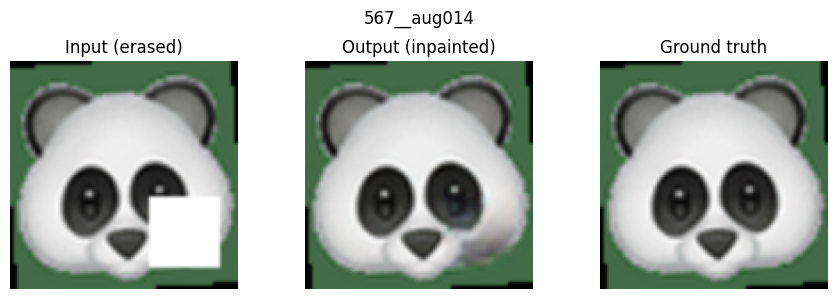

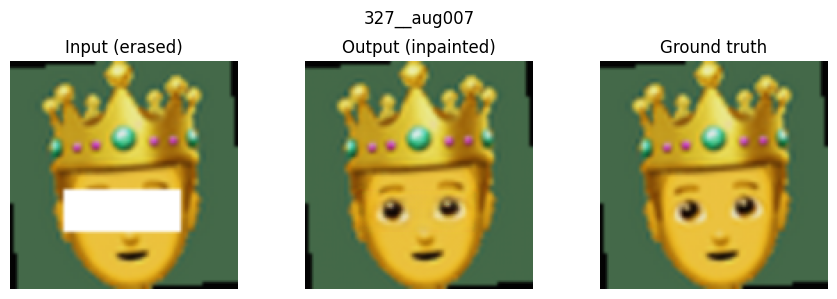

In [ ]:
# NEW CELL: Visualize randomized inpainting results

import matplotlib.pyplot as plt
import random

def show_random_results(model, dataset, num_images=5):
    """
    Randomly pick samples from dataset, then visualize:
    - Input (erased)
    - Output (inpainted)
    - Ground truth
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    @torch.no_grad()
    def to_img(t):
        return t.detach().cpu().permute(1, 2, 0).clamp(0, 1)

    for idx in indices:
        item = dataset[idx]

        inp    = item["input"].unsqueeze(0).to(DEVICE)   # [1,4,H,W]
        erased = item["erased"]                          # [3,H,W]
        target = item["target"]                          # [3,H,W]
        name   = item["name"]

        # run model
        with torch.no_grad():
            output = model(inp)[0].cpu()                 # [3,H,W]

        # plot triplet
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(to_img(erased))
        axes[0].set_title("Input (erased)")
        axes[0].axis("off")

        axes[1].imshow(to_img(output))
        axes[1].set_title("Output (inpainted)")
        axes[1].axis("off")

        axes[2].imshow(to_img(target))
        axes[2].set_title("Ground truth")
        axes[2].axis("off")

        fig.suptitle(name)
        plt.tight_layout()
        plt.show()


# Call this after training + loading best model
show_random_results(model, test_dataset, num_images=5)

In [ ]:
# === LOAD MODEL LOCAL (WINDOWS) ===

BEST_MODEL_PATH = r"C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=4, out_channels=3).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.eval()

print("Loaded best model from:")
print(BEST_MODEL_PATH)

Loaded best model from:
C:\Users\TUF\Downloads\Mini Project\triplets_out\model_output\best_unet_inpainting.pth


C:\Users\TUF\AppData\Local\Temp\ipykernel_22464\2712005636.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location

In [ ]:
# === INPAINT ALL IMAGES IN OPEN TEST DATASET (LOCAL WINDOWS PATH) ===

import os
import pandas as pd
from PIL import Image
import torchvision.utils as vutils
from torchvision import transforms

# === GANTI PATH INI SESUAI FOLDERMU ===
OTI_ROOT = r"C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI"
OTI_CSV  = os.path.join(OTI_ROOT, "index.csv")
OTI_OUT_DIR = os.path.join(OTI_ROOT, "inpainted")  # folder output

os.makedirs(OTI_OUT_DIR, exist_ok=True)

IMG_SIZE = 128

single_img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

single_mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# load index.csv
df_oti = pd.read_csv(OTI_CSV)
print("Total OTI samples:", len(df_oti))


@torch.no_grad()
def inpaint_oti_dataset(model, df, root_dir, out_dir):
    model.eval()

    for idx, row in df.iterrows():
        orig_rel   = row["orig"]
        erased_rel = row["erased"]
        mask_rel   = row["mask"]

        erased_path = os.path.join(root_dir, erased_rel)
        mask_path   = os.path.join(root_dir, mask_rel)

        erased_img = Image.open(erased_path).convert("RGB")
        mask_img   = Image.open(mask_path).convert("L")

        erased = single_img_transform(erased_img)
        mask   = single_mask_transform(mask_img)
        mask   = (mask > 0.5).float()

        model_input = torch.cat([erased, mask], dim=0).unsqueeze(0).to(DEVICE)

        pred = model(model_input)[0].cpu().clamp(0, 1)

        # simpan file output
        base_name = os.path.basename(orig_rel)
        out_path = os.path.join(out_dir, base_name)

        vutils.save_image(pred, out_path)

        print(f"[{idx+1}/{len(df)}] Saved {out_path}")


# RUN
inpaint_oti_dataset(model, df_oti, OTI_ROOT, OTI_OUT_DIR)

Total OTI samples: 20
[1/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m00.png
[2/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m01.png
[3/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m02.png
[4/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m03.png
[5/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m04.png
[6/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m05.png
[7/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m06.png
[8/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m07.png
[9/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m08.png
[10/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\inpainted\6__val_m09.png
[11/20] Saved C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI\

Total OTI samples: 20


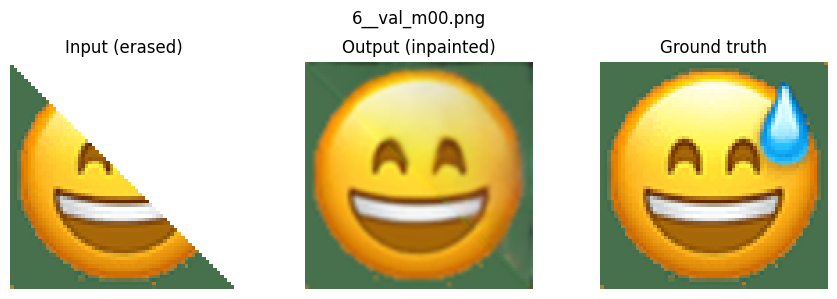

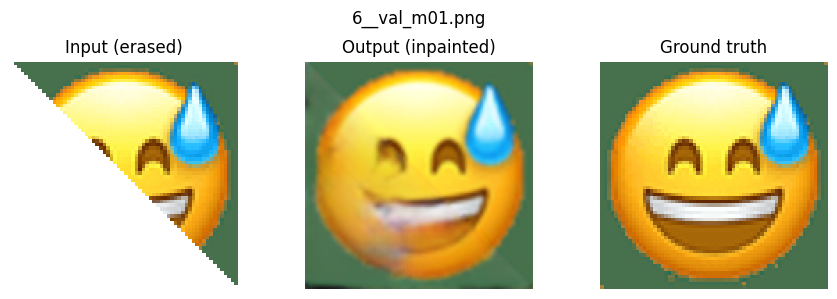

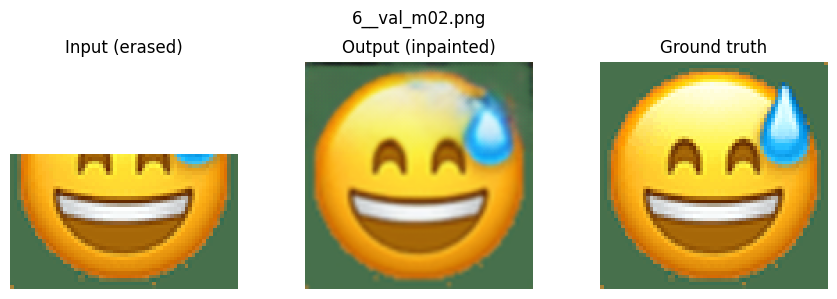

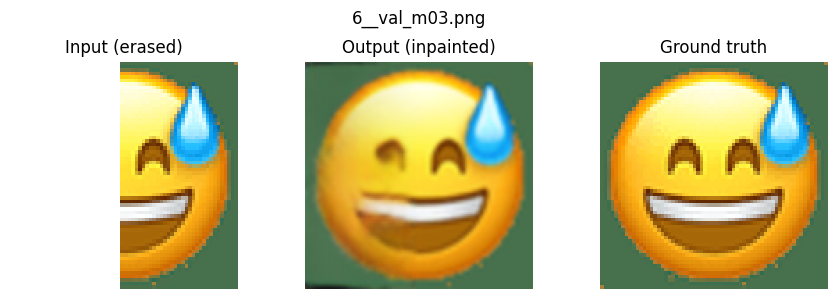

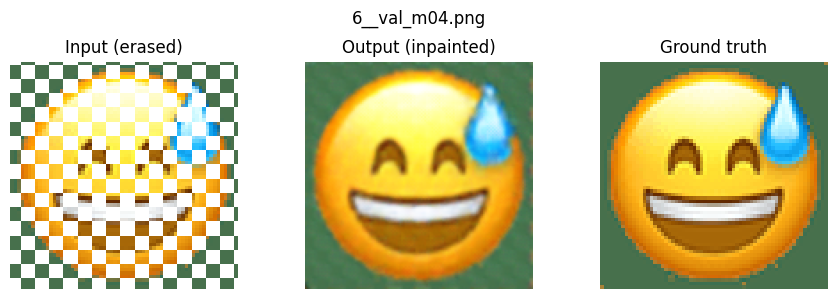

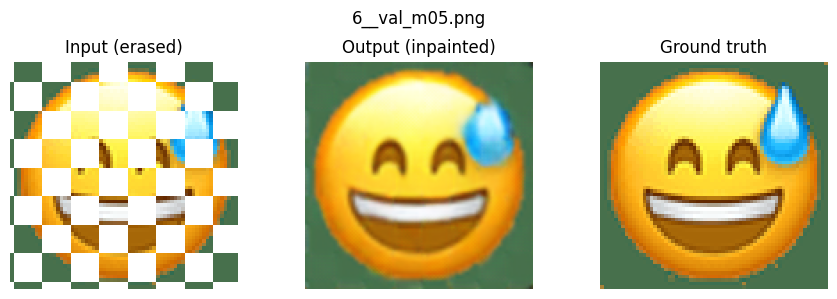

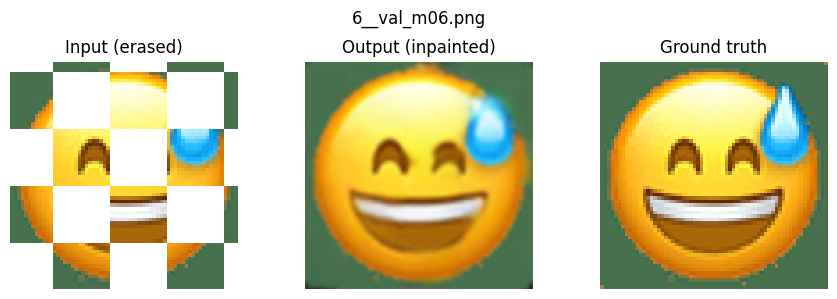

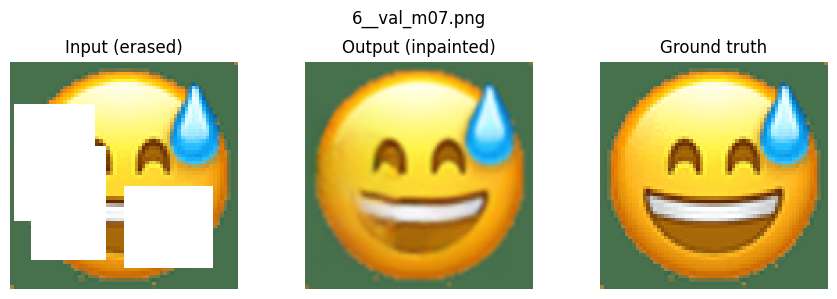

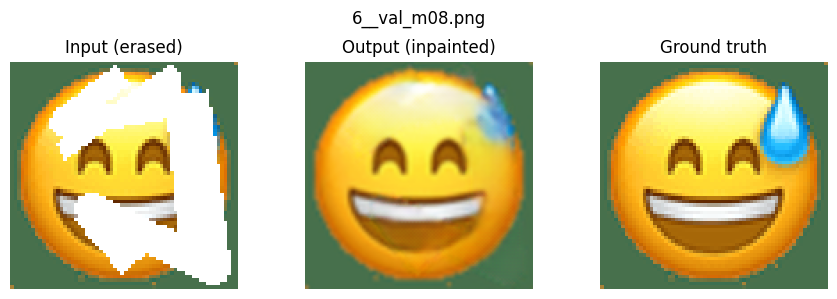

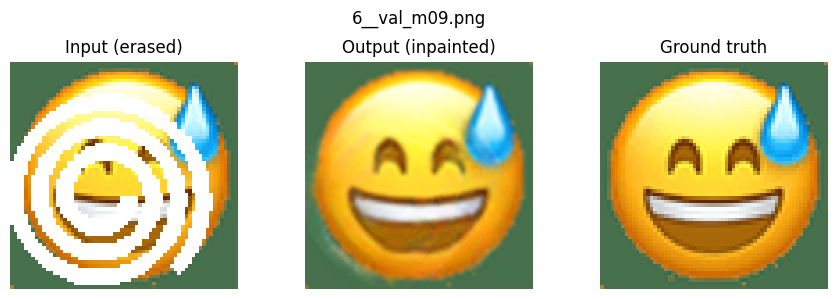

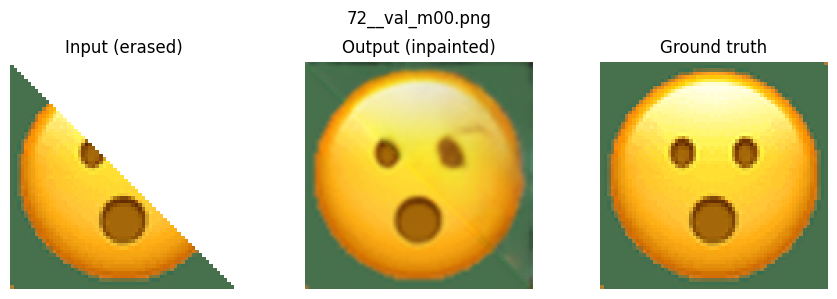

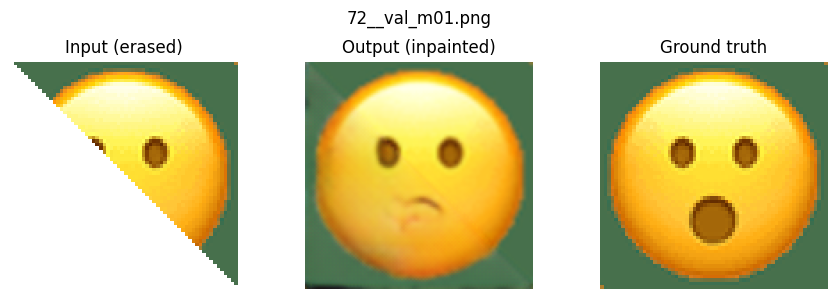

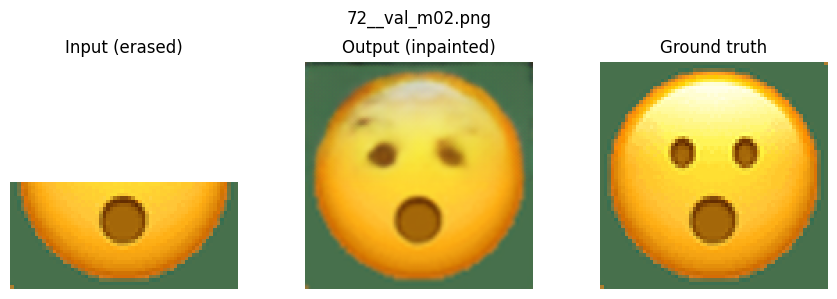

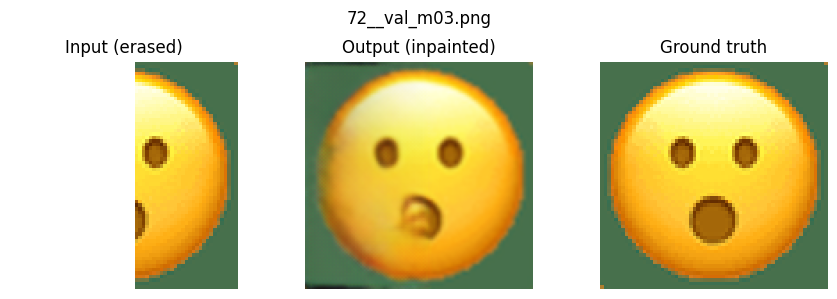

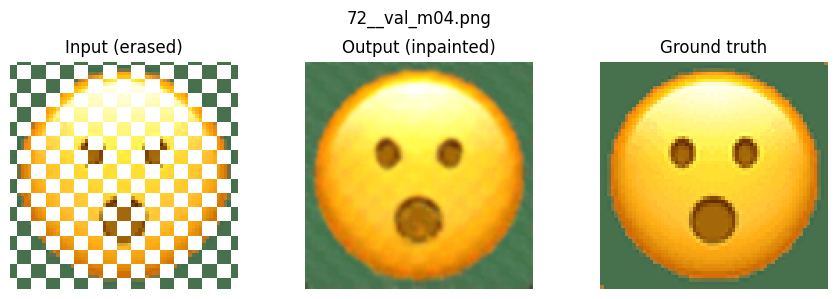

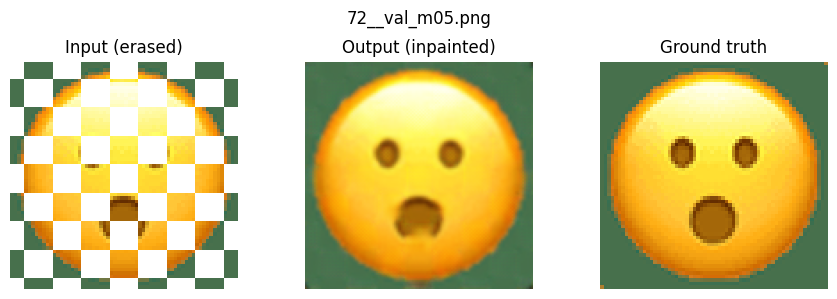

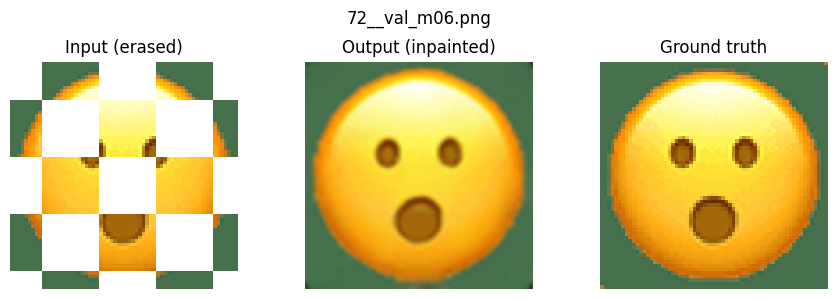

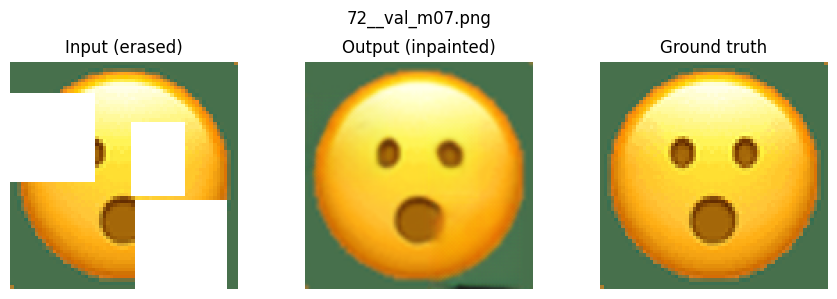

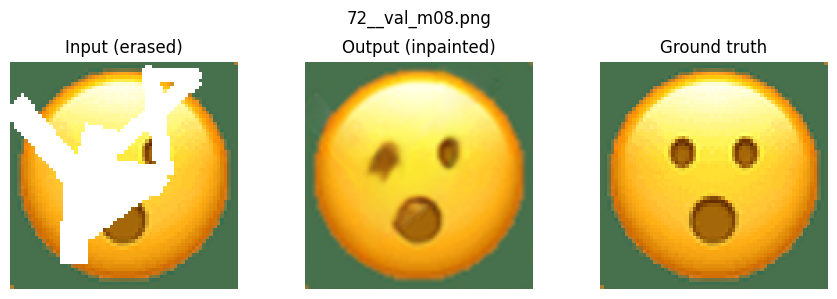

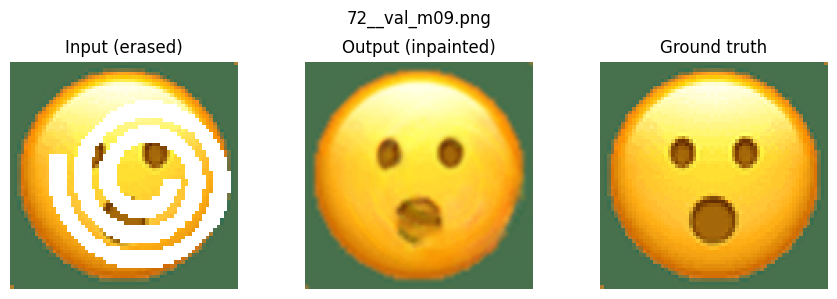

In [ ]:
# === VISUALIZE ALL 20 OTI TRIPLETS ===

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Pastikan variabel ini sama dengan yang dipakai waktu inpaint OTI
OTI_ROOT   = r"C:\Users\TUF\Downloads\Mini Project\triplets_val_OTI"
OTI_CSV    = os.path.join(OTI_ROOT, "index.csv")
OTI_OUT_DIR = os.path.join(OTI_ROOT, "inpainted_70")  # hasil inpaint

df_oti = pd.read_csv(OTI_CSV)
print("Total OTI samples:", len(df_oti))

for idx, row in df_oti.iterrows():
    orig_rel   = row["orig"]      # contoh: "orig/24__aug004.png"
    erased_rel = row["erased"]    # contoh: "erased/24__aug004_erased.png"

    # path lengkap
    orig_path      = os.path.join(OTI_ROOT, orig_rel)
    erased_path    = os.path.join(OTI_ROOT, erased_rel)
    # hasil inpaint disimpan dengan nama file yang sama seperti orig
    base_name      = os.path.basename(orig_rel)      # "24__aug004.png"
    inpainted_path = os.path.join(OTI_OUT_DIR, base_name)

    # load gambar
    orig_img      = Image.open(orig_path).convert("RGB")
    erased_img    = Image.open(erased_path).convert("RGB")
    inpainted_img = Image.open(inpainted_path).convert("RGB")

    # plot triplet
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(erased_img)
    axes[0].set_title("Input (erased)")
    axes[0].axis("off")

    axes[1].imshow(inpainted_img)
    axes[1].set_title("Output (inpainted)")
    axes[1].axis("off")

    axes[2].imshow(orig_img)
    axes[2].set_title("Ground truth")
    axes[2].axis("off")

    fig.suptitle(os.path.basename(orig_rel))
    plt.tight_layout()
    plt.show()
